# Explorative Analysis Clean Cobined Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sb
import missingno as msno
from sklearn import preprocessing as p
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import warnings

%matplotlib inline

color = sb.color_palette("Set2")[0]
palette = sb.color_palette("Set2")

In [2]:
data = pd.read_csv('../data/cleaned_data_v2-combined_v2.csv', sep=',', index_col = 0)
data.head()

,EDAD,IDINGRESO,TA_MAX_PRIMERA_URG,TA_MIN_PRIMERA_URG,TEMP_PRIMERA_URG,FC_PRIMERA_URG,SAT_02_PRIMERA_URG,GLU_PRIMERA_URG,CREA--CREATININA,DD--DIMEROD,LIN--SISTEMATICODESANGRE,NEU--SISTEMATICODESANGRE,PCR--PROTEINACREACTIVA,PLAQ--SISTEMATICODESANGRE,FEMALE,MALE,DEATH,RECOVERED,RECOVERY_IN_PROGRESS
0,55,508,0,0,0.0,0,0,0,0.705,399.000000,2.290,3.885,6.080000,472.000000,0,1,0,1,0
1,54,509,0,0,0.0,0,0,0,0.800,398.000000,2.355,4.620,13.310000,657.000000,0,1,0,1,0
2,73,510,0,0,0.0,0,0,0,1.056,4396.750000,1.482,6.082,3.760000,306.000000,0,1,0,1,0
3,70,512,0,0,0.0,0,0,0,0.670,497.333333,1.395,9.175,21.986667,278.166667,1,0,0,0,1
4,61,513,0,0,0.0,0,0,0,0.670,470.000000,1.010,6.220,7.370000,318.000000,1,0,0,1,0


In [3]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 2067
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EDAD                       5400 non-null   int64  
 1   IDINGRESO                  5400 non-null   int64  
 2   TA_MAX_PRIMERA_URG         5400 non-null   int64  
 3   TA_MIN_PRIMERA_URG         5400 non-null   int64  
 4   TEMP_PRIMERA_URG           5400 non-null   float64
 5   FC_PRIMERA_URG             5400 non-null   int64  
 6   SAT_02_PRIMERA_URG         5400 non-null   int64  
 7   GLU_PRIMERA_URG            5400 non-null   int64  
 8   CREA--CREATININA           5400 non-null   float64
 9   DD--DIMEROD                5400 non-null   float64
 10  LIN--SISTEMATICODESANGRE   5400 non-null   float64
 11  NEU--SISTEMATICODESANGRE   5400 non-null   float64
 12  PCR--PROTEINACREACTIVA     5400 non-null   float64
 13  PLAQ--SISTEMATICODESANGRE  5400 non-null   float

In [4]:
# Scatter plot
'''
sb.pairplot(data);
plt.title('Multiple Scatter Plot');
plt.savefig('../visualizations/dataset_multiple_scatter.png', bbox_inches='tight');
'''

"\nsb.pairplot(data);\nplt.title('Multiple Scatter Plot');\nplt.savefig('../visualizations/dataset_multiple_scatter.png', bbox_inches='tight');\n"

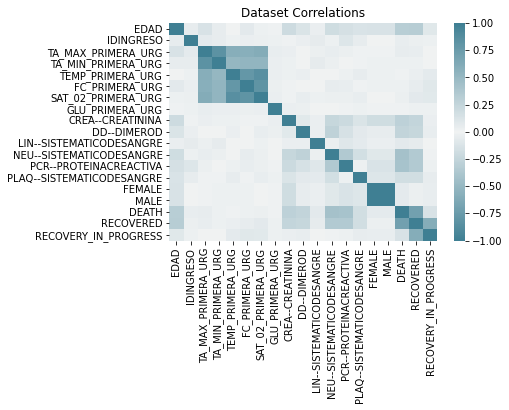

In [5]:
# Correlation Heatmap
cmap = sb.diverging_palette(220, 220, as_cmap=True)
sb.heatmap(data.corr(), cmap = cmap);
plt.title('Dataset Correlations');
plt.savefig('../visualizations/dataset_correlations.png', bbox_inches='tight')

# Exploratory Modelling

In [6]:
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, precision_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier

### Death

In [7]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_death = np.array(data_xg['DEATH'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_death, test_size=0.3, random_state=42)

In [8]:
X.columns

Index(['CREA--CREATININA', 'DD--DIMEROD', 'EDAD', 'FC_PRIMERA_URG', 'FEMALE',
       'GLU_PRIMERA_URG', 'LIN--SISTEMATICODESANGRE', 'MALE',
       'NEU--SISTEMATICODESANGRE', 'PCR--PROTEINACREACTIVA',
       'PLAQ--SISTEMATICODESANGRE', 'SAT_02_PRIMERA_URG', 'TA_MAX_PRIMERA_URG',
       'TA_MIN_PRIMERA_URG', 'TEMP_PRIMERA_URG'],
      dtype='object')

#### Random Forest

In [9]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO', 'LIN--SISTEMATICODESANGRE'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_death = np.array(data_xg['DEATH'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_death, test_size=0.3, random_state=42)

In [10]:
# intantinates
rf_model = RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.4, min_samples_leaf=1, min_samples_split=4, n_estimators=100)

In [11]:
# fit 
fr_model_fit = rf_model.fit(X_train, y_train)

# predict 
y_death_pred = fr_model_fit.predict(X_test)

In [12]:
# evaluate prediction 
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred, average='weighted'), 3)
beta = 0.90
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
pre = round(precision_score(y_test, y_death_pred), 3)
fpr, tpr, thresholds = roc_curve(y_test, y_death_pred)
auc = round(auc(fpr, tpr),3)
print(f'Death Prediction Random Forest\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}\nPrecision: {pre}\nAuc: {auc}')

Death Prediction Random Forest
Accuracy: 0.953
Recall: 0.953
F-beta (beta=0.9): 0.837
Precision: 0.907
Auc: 0.875


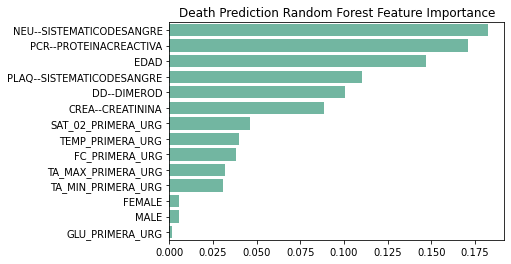

In [13]:
# feature importance
imp_feat = pd.Series(fr_model_fit.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Death Prediction Random Forest Feature Importance')
plt.savefig('../visualizations/death_random_forest_feature_importance_final.png', bbox_inches='tight')

### Recovery

In [7]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO', 'LIN--SISTEMATICODESANGRE'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_death = np.array(data_xg['RECOVERED'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_death, test_size=0.3, random_state=42)

#### Random Forest

In [8]:
# intantinates
rf_model = RandomForestClassifier()

# fit 
rf_model_fit = rf_model.fit(X_train, y_train)

# predict 
y_rec_pred = rf_model_fit.predict(X_test)

In [10]:
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_rec_pred)
auc_2 = round(auc(fpr_2, tpr_2),3)
auc_2

0.873

In [11]:
# evaluate prediction 
acc =round(accuracy_score(y_test, y_rec_pred), 3)
recall = round(recall_score(y_test, y_rec_pred), 3)
beta = 0.10
fbeta = round(fbeta_score(y_test, y_rec_pred, beta = beta), 3)
pre = round(precision_score(y_test, y_rec_pred), 3)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_rec_pred)
auc_2 = round(auc(fpr_2, tpr_2),3)
print(f'Recovery Prediction Random Forest\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}\nPrecision: {pre}\nAuc: {auc_2}')

Recovery Prediction Random Forest
Accuracy: 0.927
Recall: 0.981
F-beta (beta=0.1): 0.927
Precision: 0.926
Auc: 0.873


In [ ]:
# feature importance
imp_feat = pd.Series(rf_model_fit.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Recovery Prediction Random Forest Feature Importance')
plt.savefig('../visualizations/recovery_random_forest_feature_importance_final.png', bbox_inches='tight')